---
title: "Arrest Trends in San Francisco, 2018-2024"
bibliography: "../memos.bib"
author: "Peter Amerkhanian"
date: "2024-02-17"
title-block-banner: true
image: thumbnail.png
abstract: "I analyze arrest activity trends in San Francisco, with a particular focus on trends in the post-pandemic period."
jupyter: info251
execute:
  enabled: true
  cache: false
format:
  html:
    code-tools:
      source: https://github.com/peter-amerkhanian/peter-amerkhanian.github.io
      toggle: false
      caption: "Memo Code"
    echo: false
    warnings: false
    toc: true
    toc-depth: 3
  docx:
    echo: false
    warnings: false
    abstract: ""
editor: 
  markdown: 
    wrap: 72
---

In this memo I analyze trends in arrest and citation activity[^1] in San Francisco between 2018 and 2024. Arrest activity decreased during this period, marked by a steady decline before the pandemic, a sharp drop at the outset of the pandemic, and generally low arrest activity in the post-pandemic. In the post-pandemic, arrest levels for almost every class of crime were less than or equal to arrest levels in the pre-pandemic, except for drug sale arrests, which substantially increased. The vast majority of those increased drug sale arrests took place in the Tenderloin. Indeed, the Tenderloin was an exception to the trend of decreasing arrests in San Francisco -- arrest activity in the district increased in the post-pandemic, with drug sale arrests driving the increase.

An important caveat of this analysis is that it examines arrests and citations, not *crime.* Of all crime events, arrests only include those events that are reported to law enforcement and go on to produce an arrest. Trends in arrest do not necessarily point to equal trends in crime, rather they point to trends in how the City and Police Department are prioritizing law enforcement resources, specifically policing. Thus I conclude that in the post-pandemic, the City shifted policing resources towards the Tenderloin and prioritized making arrests for drug sale crime.  

[^1]: For convenience, I will use the term "arrests" to refer to the combination of arrests and citations.


In [1]:
#| cache: true
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from tqdm import tqdm
# Standard Libraries
from datetime import datetime, timedelta
import os
import pickle
# Geospatial Libraries
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import contextily as cx
from scipy import ndimage
import matplotlib as mpl
import matplotlib.colors as colors
from shapely.geometry import Polygon
# SFGOV API:
from sodapy import Socrata
from IPython.display import display, Markdown, Latex

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [3]:
#| output: false
%load_ext autoreload
%autoreload 2

In [4]:
import data_setup
import geospatial_utils
import stats_utilities

In [5]:
#| output: false
#| cache: true
df = data_setup.load_data()

Data successfully loaded from pickle file.


In [7]:
arrests_df = data_setup.process(df.copy())
arrests_df = data_setup.crime_type_flags(arrests_df)
# Failing to filter between the initial and supplemental report
# can lead to double counting of incidents.
arrests_df = arrests_df[arrests_df['report_type_description'] == 'Initial']

In [10]:
#| output: false
gdf_full = gpd.GeoDataFrame(
    arrests_df,
    geometry=gpd.points_from_xy(arrests_df.longitude, arrests_df.latitude)
)
gdf_full['latitude'].isna().mean()


0.005146114389811869

In [11]:
gdf_full = gdf_full.dropna(subset=['latitude'])

In [12]:
# Create GDF with arrests by district
arrests_by_dist = (
    arrests_df
    .groupby('police_district')['incident_id']
    .nunique()
    .reset_index(name="Arrests")
    )
arrests_by_dist = arrests_by_dist[arrests_by_dist['police_district'] != "Out of SF"]
gdf = gpd.read_file('data/Current Police Districts_20240213.geojson')
gdf['police_district'] = (
    gdf['district']
    .str.lower()
    .str.strip()
    )
arrests_by_dist['police_district'] = (
    arrests_by_dist['police_district']
    .str.lower()
    .str.strip()
    )
arrests_by_dist = gdf[['police_district', 'geometry']].merge(arrests_by_dist,
                                                             on='police_district',
                                                             how="inner")

In [13]:
gdf_full = gdf_full.set_crs(arrests_by_dist.crs.to_string())

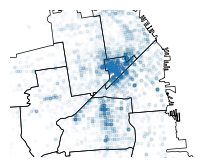

In [14]:
#| output: false
fig, ax = plt.subplots(figsize=(5, 2))
arrests_by_dist.plot(ax=ax, facecolor="none", linewidth=.5, edgecolor="black")
gdf_full.sample(10000).plot(alpha=.02, ax=ax, markersize=4)
ax.set_xlim(-122.47, -122.365)
ax.set_ylim(37.7447, 37.807)
geospatial_utils.clean_map(ax)
fig.savefig('thumbnail.png', dpi=300, bbox_inches='tight')

In [15]:
cmap = mpl.cm.get_cmap('YlOrRd')
new_cmap = (
    colors
    .LinearSegmentedColormap
    .from_list('deep_reds',
               cmap(np.linspace(0.1, 1, 100)))
               )

In [16]:
legend_cbar_kws = {
    "format": "{x:,.0f}",
    "shrink": .5,
    "label": "Arrests",
    'location': 'bottom',
    'pad': 0.01
}

## Geographic concentration in the Tenderloin

[@fig-tenderloin] shows that arrests were geographically concentrated in the Tenderloin district over the six-year analysis period. The left-hand panel depicts the general concentration of arrests in downtown police districts -- Northern, Central, Southern, the Tenderloin, and the Mission. However, viewing the geographic trends by district obscures more specific patterns illustrated at a block-level in the right panel. Arrest activity along the Northern, Central, and Southern districts' borders with the Tenderloin accounted for the high arrest numbers in those districts.

In [17]:
gdf_hist = geospatial_utils.build_geohist(gdf_full, bins=75)

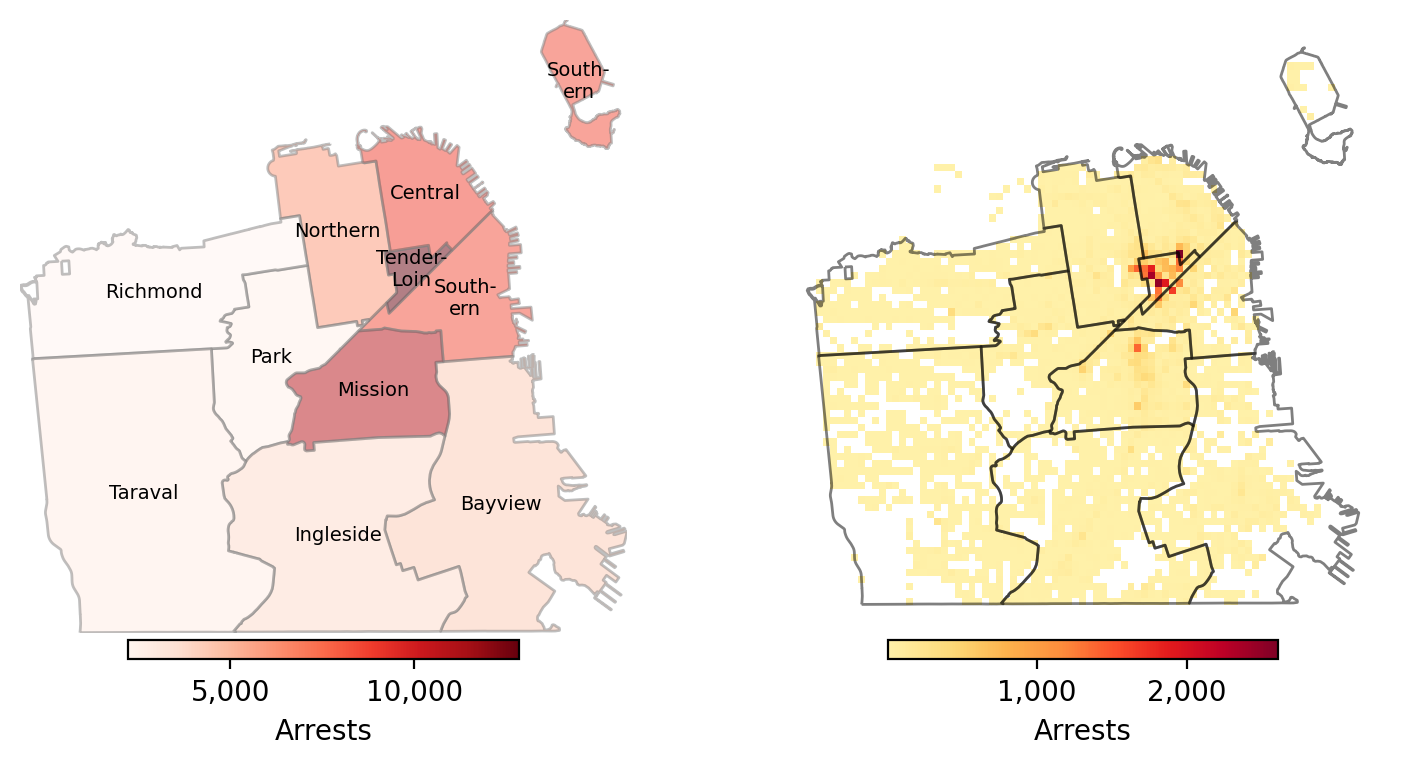

In [18]:
#| label: fig-tenderloin
#| fig-cap: "Geographic Trends in Arrests (2018-2024), by Police District (Left) and by Block Segment (Right)"
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
xlim, ylim = geospatial_utils.get_bounds(arrests_by_dist)
arrests_by_dist.plot(column="Arrests", legend=True, cmap="Reds", ax=ax[0], alpha=.5, linewidth=1, edgecolor="grey", legend_kwds=legend_cbar_kws)
ax[0].set(xlim = xlim, ylim = ylim)
geospatial_utils.clean_map(ax[0])
ax[0].grid(alpha=0)
for idx, row in arrests_by_dist.iterrows():
    label = row['police_district'].title()
    if label == "Tenderloin":
        label = "Tender-\nLoin"
    if label == "Southern":
        label = "South-\nern"
    geospatial_utils.label_polygon(ax[0], label, row, idx, arrests_by_dist, textsize=7)
gdf_hist.plot(ax=ax[1], column='value', legend=True, legend_kwds=legend_cbar_kws, cmap=new_cmap)
arrests_by_dist.plot(ax=ax[1], facecolor="none", linewidth=1, edgecolor="black", alpha=.5)
geospatial_utils.clean_map(ax[1])
fig.tight_layout()
fig.set_dpi(200)

In [19]:
corners = gdf_full.groupby(['police_district', 'intersection'])['incident_id'].nunique().reset_index()
corners_gdf = (
    gdf_full[['police_district', 'intersection', 'geometry']]
    .drop_duplicates(subset=['police_district', 'intersection'])
    .merge(corners,
           on=['police_district', 'intersection'],
           how='inner')
    .sort_values(by='incident_id', ascending=False)
    )
corners_gdf = corners_gdf.reset_index(drop=True).reset_index()

In [20]:
corners_gdf['label'] = (
    (corners_gdf['index'] + 1).astype(str) +
    ": " +
    corners_gdf['intersection'].str.strip().str.replace("\\", "/\n") +
    "\n (" + corners_gdf['police_district'] +
    ")"
)

In [21]:
#| output: false
gt_buffer = .0002
greater_tenderloin = arrests_by_dist[arrests_by_dist['police_district'] == 'tenderloin'].geometry.buffer(gt_buffer).iloc[0]

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_84\3591840669.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [22]:
corners_gdf['Tenderloin or\nWithin ~2 Blocks\nof Tenderloin'] = corners_gdf.within(
    greater_tenderloin
)
corners_gdf ['Location'] = corners_gdf['Tenderloin or\nWithin ~2 Blocks\nof Tenderloin'].replace({True: 'Inside\nGreater Tenderloin', False: 'Outside of \nGreater Tenderloin'})

In [23]:
pct_tenderloin = (
    (corners_gdf['Tenderloin or\nWithin ~2 Blocks\nof Tenderloin'] * corners_gdf['incident_id']).sum() /
    corners_gdf['incident_id'].sum()
    )
pct_tenderloin_txt = f"{pct_tenderloin:.0%}"

In [24]:
#| output: false
land_area = greater_tenderloin.area / arrests_by_dist.area.sum()
land_area_txt = f"{land_area:.2%}"

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_84\3096037156.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




At the block level, we can specifically classify **"the greater Tenderloin,"** the area inside of the Tenderloin plus the corners along its border streets,^[A map defining the "greater Tenderloin" is available in Appendix @sec-gt] as having particularly high arrest activity. The greater Tenderloin represents `{python} land_area_txt` of the square miles of San Francisco, but made up `{python} pct_tenderloin_txt` of the total arrests in the City during the analysis period. Of the top ten street corners in San Francisco ranked by total arrest activity 2018-2024, shown in [@fig-2], almost all of them were in the greater Tenderloin.  

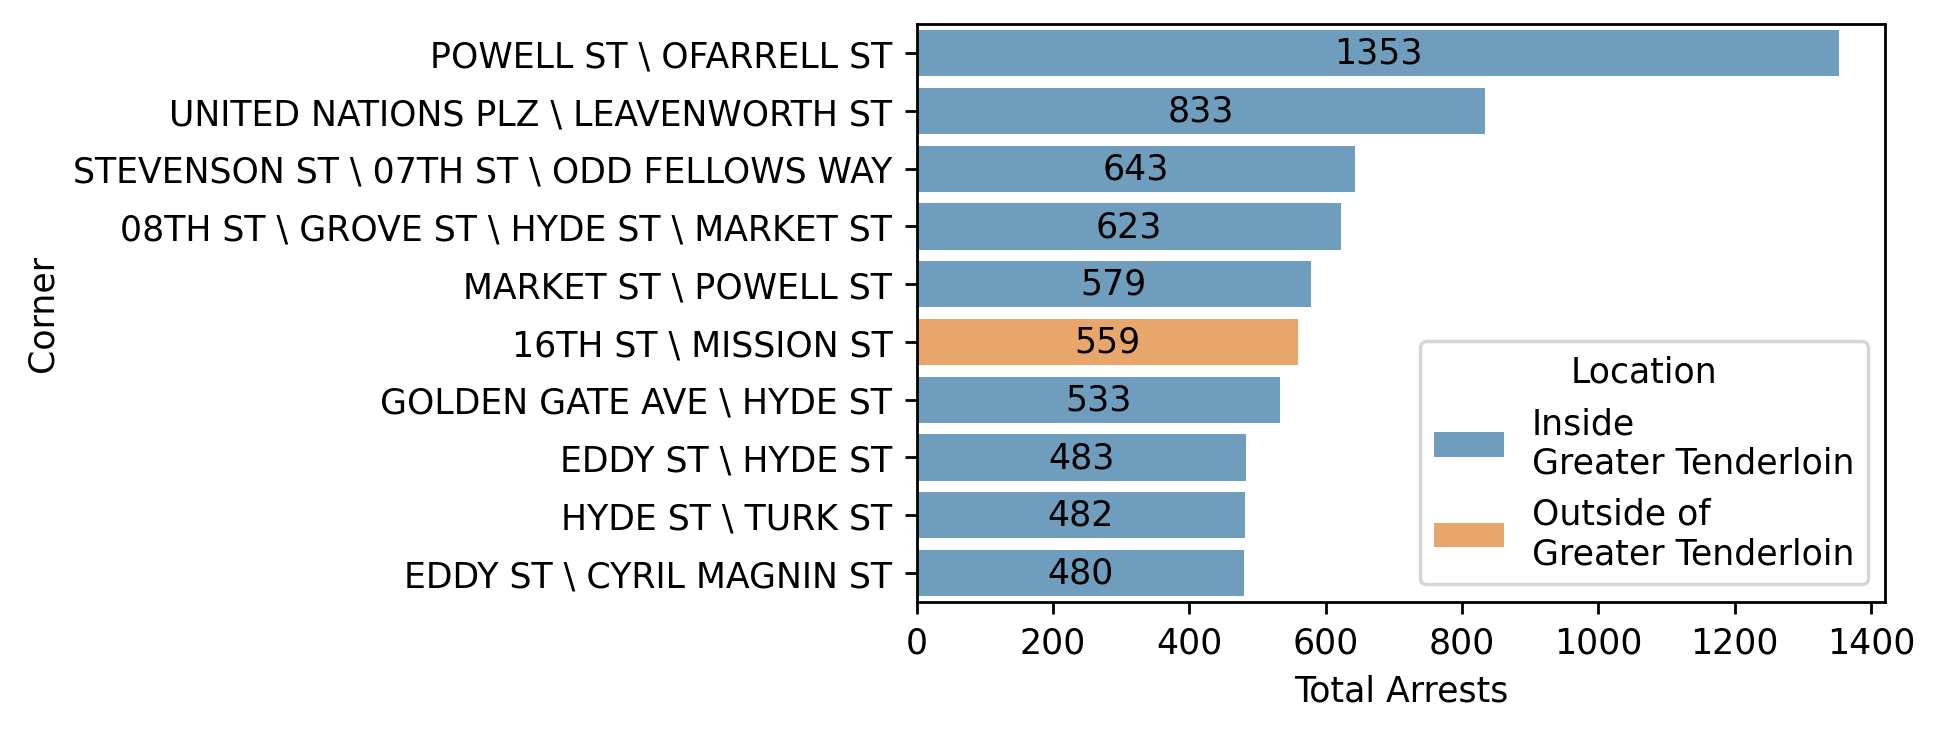

In [25]:
#| label: fig-2
#| fig-cap: "Ten Corners with the Highest Arrest Activity (2018-2024)"
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(corners_gdf.head(10), x='incident_id', y='intersection', hue='Location', dodge=False, ax=ax, alpha=.7)
ax.set(ylabel="Corner", xlabel="Total Arrests")
for container in ax.containers:
    ax.bar_label(container, label_type='center')
fig.set_dpi(250)

## Changes in post-pandemic arrest patterns

In [26]:
CHART_PERIOD = "ME"
TEST_PERIOD = "W"

In [27]:
arrests_by_month = arrests_df.resample("ME")['incident_id'].nunique().iloc[0:-1]
pct_change = 1 - (arrests_by_month.loc["2020-4"].iloc[0] / arrests_by_month.loc["2020-2"].iloc[0])
real_change = (arrests_by_month.loc["2020-4"].iloc[0] - arrests_by_month.loc["2020-2"].iloc[0])

In [28]:
arrests_df['pre_pandemic'] = (arrests_df.index < '2020') & (arrests_df.index >= '2018')
arrests_df['post_pandemic'] = (arrests_df.index >= '2022') & (arrests_df.index < '2024')
testing_df = arrests_df[arrests_df['pre_pandemic'] |arrests_df['post_pandemic']]
testing_df['Time Period'] = testing_df['post_pandemic'].replace({
    True: "Post Pandemic (2022-24)",
    False: "Pre Pandemic (2018-20)"
})
pandemic_impact = (testing_df
 .groupby('Time Period').resample(CHART_PERIOD)['incident_id']
 .nunique()
 .reset_index()
 .groupby('Time Period')['incident_id'].mean()
 .reset_index()
 .sort_values(by='incident_id', ascending=False)
 .assign(Difference = lambda x: x['incident_id'].diff())
 .assign(Percent = lambda x: x['incident_id'].pct_change())
 .rename(columns={'incident_id': 'Average Monthly Arrest Total'})
 )

In [29]:
pct_impact = pandemic_impact.query("(`Time Period` == 'Post Pandemic (2022-24)')")['Percent'].iloc[0]
pct_impact = f"{pct_impact:.0%}"

The onset of the pandemic and the accompanying city-wide shelter-in-place order were associated with a large drop in arrests at the city level. Between February and April 2020 -- the immediate outset of the pandemic -- monthly arrests decreased by `{python} f"{pct_change:.0%}"` (`{python} real_change` arrests) in San Francisco. This trend aligns with prior study of the pandemic's effects on crime and policing. In a national analysis that included San Francisco and 11 other major cities, @abrams_covid_2021 found that shelter-in-place orders and the pandemic itself caused substantial and immediate reductions in many types of criminal behavior and their accompanying arrest activity.

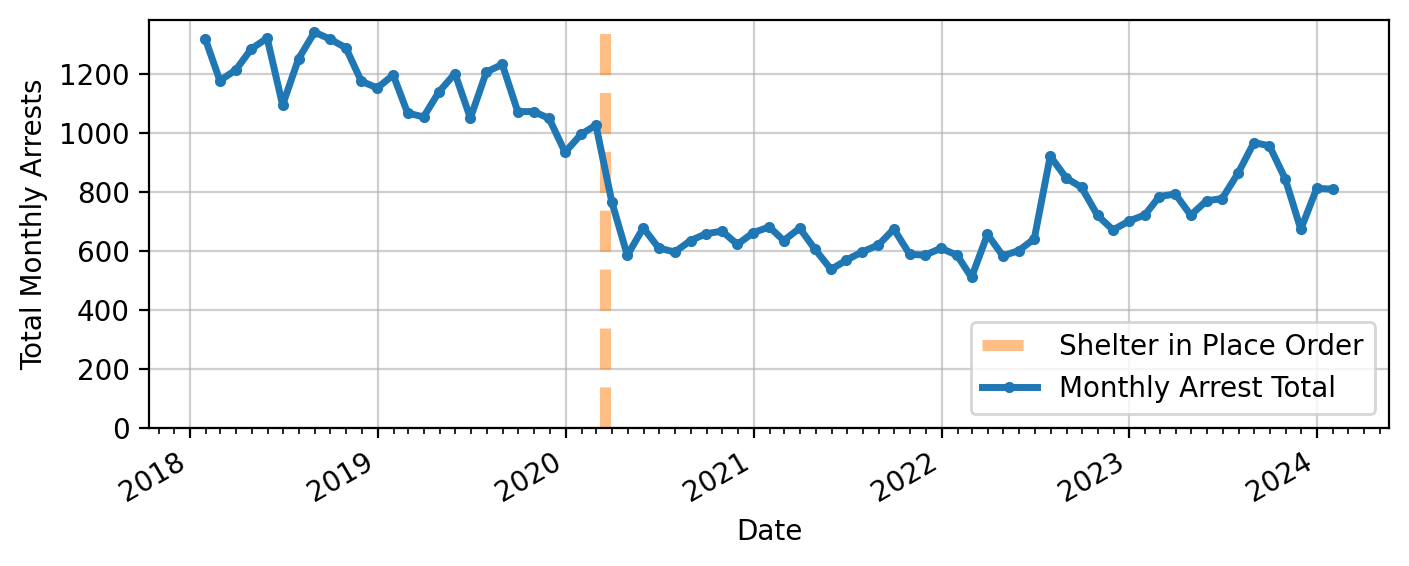

In [30]:
#| label: fig-3
#| fig-cap: "Monthly Arrest Totals, City-wide, 2018-2024"
fig, ax = plt.subplots(figsize=(8, 3))
ax.axvline(data_setup.shelter_in_place, linestyle="--", linewidth=4, alpha=.5,
           color="tab:orange", label="Shelter in Place Order")
arrests_by_month.plot(linewidth=2.5, label="Monthly Arrest Total", marker=".")
ax.grid(alpha=.6)
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.set(xlabel="Date", ylabel="Total Monthly Arrests", ylim=0)
ax.legend(loc="lower right");
fig.set_dpi(200)

In [31]:
pandemic_impact = (testing_df
 .groupby('Time Period').resample(TEST_PERIOD)['incident_id']
 .nunique()
 .reset_index()
 .groupby('Time Period')['incident_id'].mean()
 .reset_index()
 .sort_values(by='incident_id', ascending=False)
 .assign(Difference = lambda x: x['incident_id'].diff())
 .assign(Percent = lambda x: x['incident_id'].pct_change())
 .rename(columns={'incident_id': 'Average Weekly Arrest Total'})
 )

 While the short-term drop in arrests is intuitive to some degree, it is less intuitive that arrest activity remained depressed for years after the onset of the pandemic. [@tbl-post] defines two distinct, two-year periods:  

 - the "pre-pandemic," 1/1/2018-1/1/2020,^[The U.S. reported its [first COVID-19 case](https://www.cdc.gov/museum/timeline/covid19.html#:~:text=January%2020%2C%202020,respond%20to%20the%20emerging%20outbreak.) in January 2020] and
 - the "post-pandemic," 1/1/2022-1/1/2024

The table shows that average weekly arrests in the post-pandemic period were still down `{python} pct_impact` from the pre-pandemic.

In [32]:
#| label: tbl-post
#| tbl-cap: "Weekly Arrest Totals in the pre/post pandemic"
(pandemic_impact
 .style.format({'Average Weekly Arrest Total': '{:,.0f}', 'Difference': '{:,.0f}', 'Percent': '{:.0%}'}, precision=1, na_rep = "-")
 .hide(axis="index")
 )

Time Period,Average Weekly Arrest Total,Difference,Percent
Pre Pandemic (2018-20),269,-,-
Post Pandemic (2022-24),171,-98,-36%


In [33]:
def core_test(ts1, ts2, testing_day_df, outcomes, blocksize=2, n_bootstraps=10000, bs_path='city_bootstrap.pickle'):
    ols_models = []
    if not os.path.exists(bs_path):
        bootstrap_models = []
    else:
        with open(bs_path, "rb") as f:
            bootstrap_models = pickle.load(f)
    newey_models = []
    for y in tqdm(outcomes):
        ols_mod = sm.OLS.from_formula(formula=F"{y} ~ post_pandemic", data=testing_day_df).fit()
        newey_west = ols_mod.get_robustcov_results(cov_type='HAC', maxlags=blocksize-1)
        ols_models.append(ols_mod)
        newey_models.append(newey_west)
        if not os.path.exists(bs_path):
            observed_diff, bootstrap_diffs = stats_utilities.block_bootstrap(ts1[y],
                                                                                ts2[y],
                                                                                blocksize,
                                                                                n_bootstraps,
                                                                                tests=len(outcomes)
                                                                                )
            bootstrap_models.append((observed_diff, bootstrap_diffs))
    if not os.path.exists(bs_path):
        with open(bs_path, "wb") as f:
            pickle.dump(bootstrap_models, f)

    def build_ols_table(alpha, models, method):
        hac_models_df = pd.concat(
            [stats_utilities.table_to_pandas(m.summary(alpha=alpha).tables[1]).set_index("").loc[['post_pandemic']] for m in models],
            axis=0)
        hac_models_df['method'] = method
        hac_models_df['outcome'] = outcomes
        hac_models_df = hac_models_df.sort_values(by='coef')
        hac_models_df = hac_models_df.rename(columns={hac_models_df.columns[4]: 'lower', hac_models_df.columns[5]: 'upper'}).set_index('outcome')[['coef', 'lower', 'upper']]
        hac_models_df['significant'] = np.abs(hac_models_df['coef']) > np.abs(hac_models_df['coef'] - hac_models_df['lower'])
        return hac_models_df
    
    def build_bootstrap_table(p, models, method):
        ci_lowers = []
        ci_uppers = []
        for model in models:
            emp_distribution = model[1]
            ci_lowers.append(np.percentile(emp_distribution, p/2))
            ci_uppers.append(np.percentile(emp_distribution, 100-p/2))
        bs_models_df = (
            pd.DataFrame({
                'coef': [model[0] for model in bootstrap_models],
                'upper': ci_uppers,
                'lower': ci_lowers
            })
            .assign(significant = lambda x: np.abs(x['coef']) >  np.abs(x['coef'] - x['lower']))
            .assign(outcome = outcomes)
            )
        bs_models_df['method'] = method
        return bs_models_df
    alpha = .05/len(outcomes)
    ols_models_df = build_ols_table(alpha, ols_models, 'OLS')
    ols_models_nb_df = build_ols_table(.05, ols_models, 'OLS')
    ols_models_nb_df = ols_models_nb_df.loc[ols_models_df.index]
    newey_models_df = build_ols_table(alpha, newey_models, 'NEWEY')
    newey_models_df = newey_models_df.loc[ols_models_df.index]
    newey_models_nb_df = build_ols_table(.05, newey_models, 'NEWEY_NB')
    newey_models_nb_df = newey_models_nb_df.loc[ols_models_df.index]
    p = 5 / len(outcomes)
    bs_models_df = build_bootstrap_table(p, bootstrap_models, 'Bootstrap')
    bs_models_df = bs_models_df.set_index('outcome').loc[ols_models_df.index]
    bs_models_nb_df = build_bootstrap_table(5, bootstrap_models, 'Bootstrap')
    bs_models_nb_df = bs_models_nb_df.set_index('outcome').loc[ols_models_df.index]
    return ols_models_df, newey_models_df, bs_models_df, ols_models_nb_df, newey_models_nb_df, bs_models_nb_df


In [34]:
block_size = 4

In [35]:
testing_day_df = data_setup.build_test_dataset(TEST_PERIOD, arrests_df=arrests_df)
ts1 = testing_day_df[testing_day_df['post_pandemic'] == 1]
ts2 = testing_day_df[testing_day_df['post_pandemic'] == 0]

In [36]:
#| output: false
ols_models_df, newey_models_df, bs_models_df, ols_models_nb_df, newey_models_nb_df, bs_models_nb_df = core_test(ts1, ts2, testing_day_df, outcomes = testing_day_df.columns[:-2], blocksize=block_size, bs_path='city_bootstrap.pickle')


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 89.91it/s]


100%|██████████| 9/9 [00:00<00:00, 88.15it/s]

In [37]:
arrests_imp = round(ols_models_df.loc['traffic', 'coef'], 2)
arrests_imp = f"{arrests_imp:,.2f}"

The general decrease in arrest activity in the post-pandemic was driven by a large decrease in traffic violation arrests, down `{python} arrests_imp` arrests a week on average. Arrests for some violent crimes -- robbery and assault -- also decreased, as did larceny theft arrests. 

In the post-pandemic, homicide, burglary, weapons, and drug-use[^1] arrests all returned to or else never deviated from pre-pandemic levels. Their average weekly arrest levels in the post-pandemic were not statistically distinguishable from the pre-pandemic.

Sale of drugs was the only incident category where arrest activity significantly increased in the post-pandemic. Arrest tied to the sale of drugs[^2] increased by `{python} round(ols_models_df.loc['drug_sale', 'coef'], 2)` arrests a week on average. It is notable that drug sale arrests increased while drug-use arrests did not. [@fig-city-changes] shows trends for each arrest type, using a statistical approach detailed in the Methods Appendix @sec-appendix.  

[^1]: "Drug-use arrests" are defined in Appendix [@sec-drug-use]  
[^2]: "Drug-sale arrests" are defined in Appendix [@sec-drug-sale] 


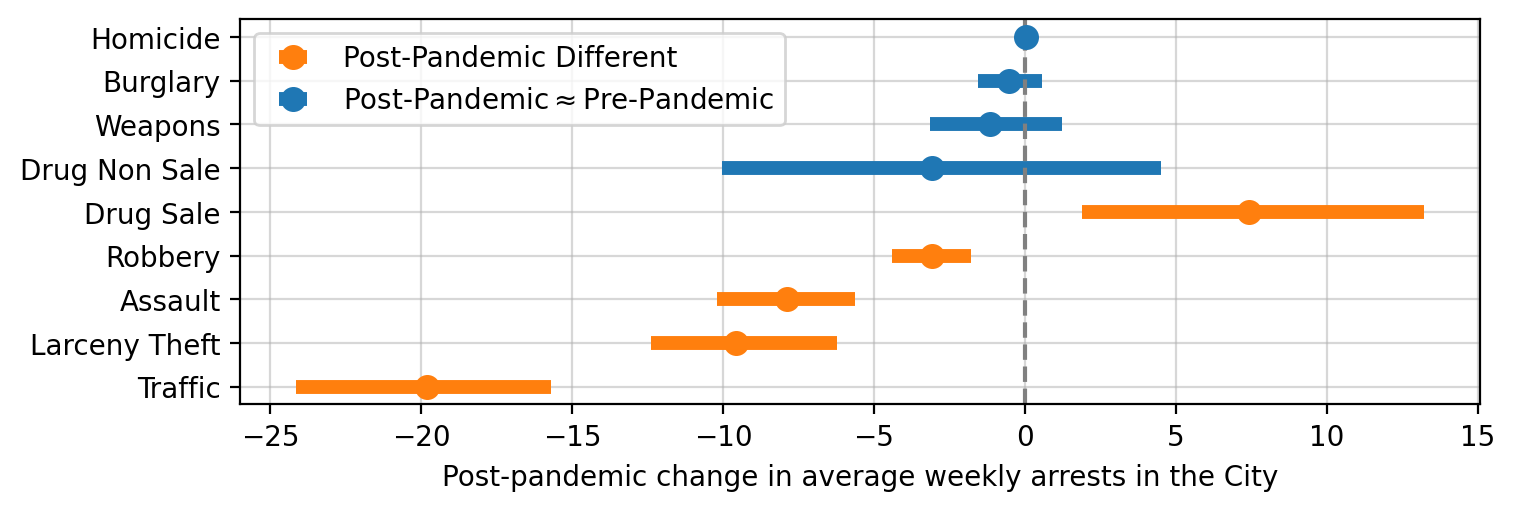

In [38]:
#| label: fig-city-changes
#| fig-cap: "Change in Average Weekly Arrests, 2018-2020 to 2022-2024"
x = ols_models_df['coef']
y = ols_models_df.index.str.title().str.replace("_", " ")
dy = np.abs(ols_models_df['coef'] - ols_models_df['lower'])
p = (np.abs(ols_models_df['coef']) > dy) 

bs_x = bs_models_df['coef']
bs_y = bs_models_df.index.str.title().str.replace("_", " ")
bs_dy = np.vstack([np.abs(bs_models_df['coef'] - bs_models_df['lower']), np.abs(bs_models_df['coef'] - bs_models_df['upper'])])
bs_p = bs_models_df['significant']
bs_p = bs_p

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.grid(alpha=.5)
# ax.errorbar(x[p], y[p], xerr=(dy[p],), linewidth=5, alpha=1, fmt='o', markersize=8, label='Post-Pandemic Different', ecolor="tab:orange", color="tab:orange")
# ax.errorbar(x[~p], y[~p], xerr=(dy[~p],), linewidth=5, alpha=1, fmt='o', markersize=8, label=r'Post-Pandemic$\approx$Pre-Pandemic', ecolor="tab:blue", color="tab:blue")
ax.errorbar(bs_x[bs_p.values], bs_y[bs_p.values], xerr=bs_dy.T[bs_p.values].T, fmt='o',label='Post-Pandemic Different', markersize=8, linewidth=5, alpha=1, ecolor="tab:orange", color="tab:orange")
ax.errorbar(bs_x[~bs_p.values], bs_y[~bs_p.values], xerr=bs_dy.T[~bs_p.values].T, fmt='o', label=r'Post-Pandemic$\approx$Pre-Pandemic', markersize=8, linewidth=5, alpha=1, ecolor="tab:blue", color="tab:blue")
ax.axvline(0, color="grey", linestyle="--")
ax.set(xlabel="Post-pandemic change in average weekly arrests in the City")
ax.legend(loc="upper left")
fig.set_dpi(200);

In [39]:
order = ols_models_df.index

In [40]:
drug_sale_post_pand = (
    gdf_full
    [(gdf_full['post_pandemic'] == True) & (gdf_full['drug_sale'] == True)]
    ['police_district']
    .value_counts(normalize=True)
    .head(5)
    .to_frame(name="Drug Sale Arrests in Post-Pandemic")
    .rename(index={"Tenderloin": "Greater Tenderloin"})
    .rename_axis('District')
    .reset_index()
    )

In [41]:
tl_drug_sale = drug_sale_post_pand.query("District == 'Greater Tenderloin'")['Drug Sale Arrests in Post-Pandemic'].iloc[0]
tl_drug_sale = f"{tl_drug_sale:.0%}"

In the post-pandemic, `{python} tl_drug_sale` of all drug sale arrests in the City took place in the greater Tenderloin. The greater Tenderloin is also the only region in the city where arrest activity returned to and in some months exceeded pre-pandemic levels. Other districts generally saw arrest levels drop slightly, or, in the Mission's case, drop significantly.

In [42]:
gdf_full['district'] = gdf_full['police_district']
gdf_full['two_block_tenderloin'] = gdf_full.within(
    greater_tenderloin
    )
gdf_full.loc[gdf_full['two_block_tenderloin'], 'district'] = 'Tenderloin'
# drug_sale_post_pand.head(5).style.format({'Drug Sale Arrests in Post-Pandemic': '{:.2%}'}).hide()

In [43]:
arrests_by_month_by_dist = gdf_full.groupby('district').resample(CHART_PERIOD)['incident_id'].nunique().reset_index()
arrests_by_month_by_dist = arrests_by_month_by_dist[arrests_by_month_by_dist['incident_datetime'] < datetime(
    2024, 2, 1)]

subset = arrests_by_month_by_dist[~arrests_by_month_by_dist['district'].isin(
    ["Out of SF"])]

aug = []
for d in subset['district'].unique():
    ds = subset.copy()[subset['district'] == d]
    ds['pct_change'] = ds['incident_id'].pct_change().cumsum()
    aug.append(ds)
aug_sub = pd.concat(aug, axis=0)
aug_sub['district'] = aug_sub['district'].replace({"Tenderloin": "Greater Tenderloin"})

In [44]:
unique_districts = aug_sub.groupby('district')['incident_id'].sum().sort_values(ascending=False)

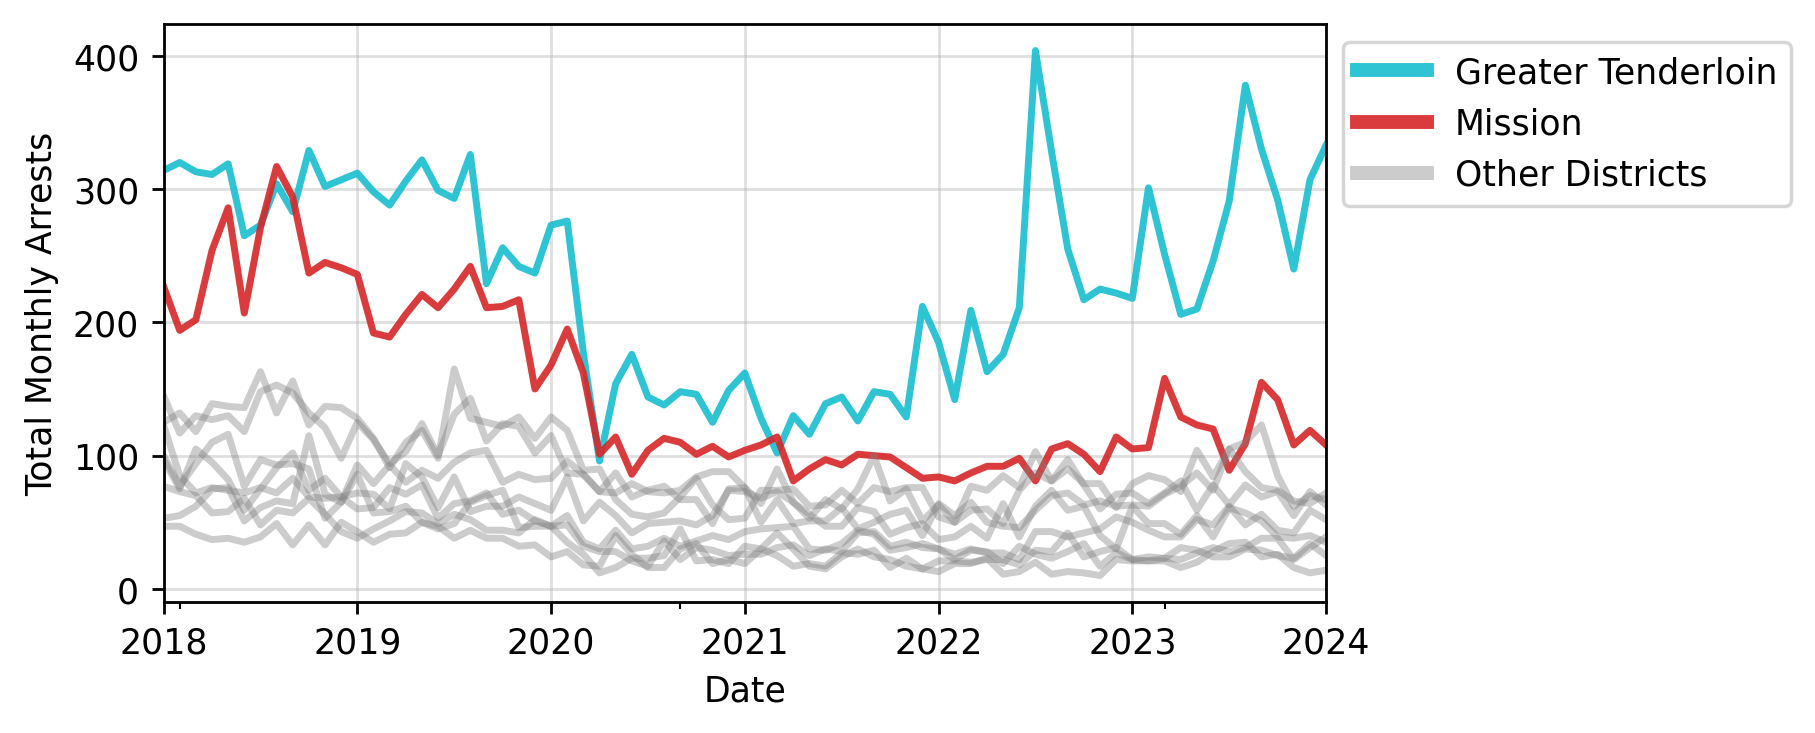

In [45]:
#| label: fig-all-districts
#| fig-cap: "Monthly Arrest Totals by District, 2018-2024"
fig, ax = plt.subplots(figsize=(6, 3))
label_other = True
for dist in unique_districts.index:
    district = aug_sub[aug_sub['district'] == dist].set_index('incident_datetime')
    if dist == "Greater Tenderloin":
        color = sns.color_palette("tab10")[-1]
        alpha = .9
        label = "Greater Tenderloin"
        district['incident_id'].plot(ax=ax, alpha=alpha, linewidth=2, color=color, label=label)
    elif dist == "Mission":
        color = sns.color_palette("tab10")[3]
        alpha = .9
        label = "Mission"
        district['incident_id'].plot(ax=ax, alpha=alpha, linewidth=2, color=color, label=label)
    else:
        color = "grey"
        alpha = .4
        label = "Other Districts"
        if label_other:
            district['incident_id'].plot(ax=ax, alpha=alpha, linewidth=2, color=color, label=label)
        else:
            district['incident_id'].plot(ax=ax, alpha=alpha, linewidth=2, color=color, label="_Hidden")
        label_other = False

stats_utilities.custom_legend(ax, outside_loc="upper", order="desc", linewidth=4)
ax.set(xlabel="Date", ylabel="Total Monthly Arrests")
ax.grid(alpha=.4)
ax.xaxis.set_minor_locator(dates.MonthLocator())
fig.set_dpi(250);

In [46]:
# #| output: false
# testing_day_df = testing_df[testing_df['police_district'] == 'Tenderloin'].resample(PERIOD)[['incident_id', 'post_pandemic']].agg({'incident_id': 'nunique', 'post_pandemic': 'max'})
# ts1 = testing_day_df.loc[testing_day_df['post_pandemic'] == 1, 'incident_id']
# ts2 = testing_day_df.loc[testing_day_df['post_pandemic'] == 0, 'incident_id']
# arrests_test = stats_utilities.block_bootstrap(ts1, ts2, block_size=1, n_bootstraps=1000)

In [47]:
#| output: false
testing_day_df_t = data_setup.build_test_dataset(TEST_PERIOD, arrests_df=arrests_df[arrests_df['police_district'] == 'Tenderloin'])
ts1_t = testing_day_df_t[testing_day_df_t['post_pandemic'] == 1]
ts2_t = testing_day_df_t[testing_day_df_t['post_pandemic'] == 0]
ols_models_df_t, newey_models_df_t, bs_models_df_t, ols_models_nb_df_t, newey_models_nb_df_t, bs_models_nb_df_t = core_test(ts1_t, ts2_t, testing_day_df_t, outcomes = testing_day_df_t.columns[:-2], blocksize=block_size, bs_path='tl_bootstrap.pickle')


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 138.42it/s]

In [48]:
tl_drug_sale_increase = f"{round(ols_models_df_t.loc['drug_sale', 'coef'], 2)}"

The greater Tenderloin also saw a meaningful change in the composition of arrests in the post-pandemic, marked by a growing emphasis on drug sale arrests. [@fig-5] shows that for most arrest types in the greater Tenderloin, average weekly arrest levels were essentially equal in the pre and post-pandemic. Drug use arrests rose on their face, but the increase was not statistically significant, suggesting that the weekly arrest totals were highly variable and not consistently elevated.  

Drug sale arrests saw a large and statistically significant increase, with `{python} tl_drug_sale_increase` more arrests a week on average in the post-pandemic. This increase is consistent with media coverage of the City's aggressive approach to drug crime in the Tenderloin. @neilson_sf_2023 also suggests that policing in the Tenderloin was more aggressive in the post-pandemic, with a particular focus on making arrests for drug sale.

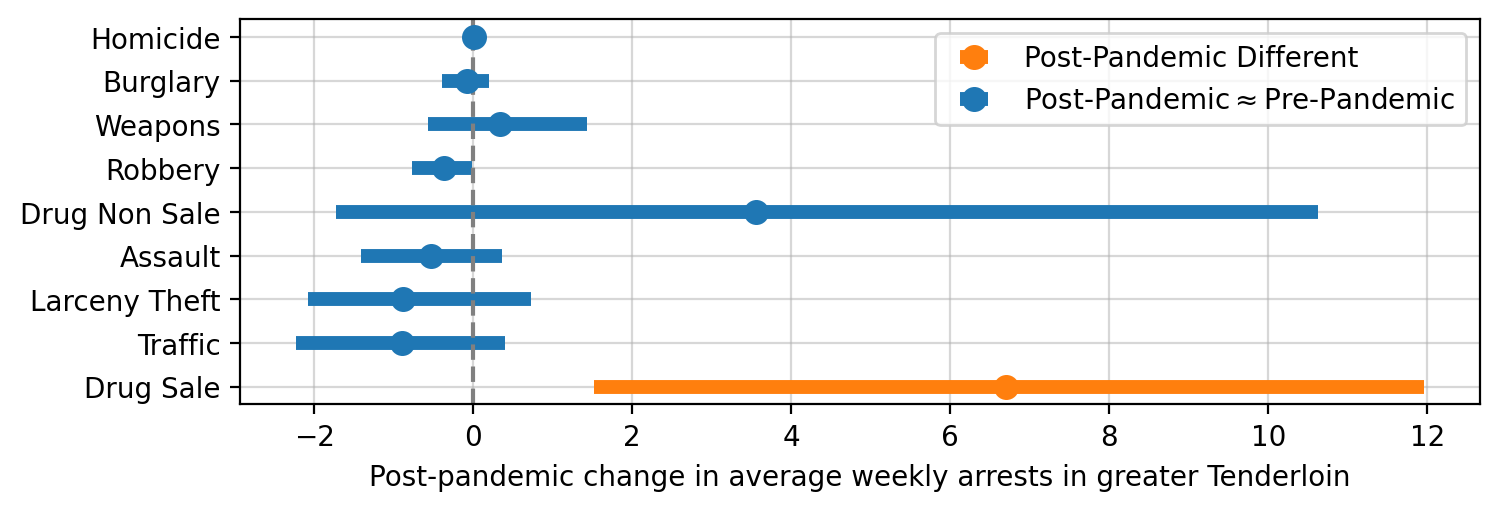

In [49]:
#| label: fig-5
#| fig-cap: "Change in Average Weekly Arrests in the Tenderloin, 2018-2020 to 2022-2024"
ols_models_df_t = ols_models_df_t.loc[order]
x = ols_models_df_t['coef']
y = ols_models_df_t.index.str.title().str.replace("_", " ")
dy = np.abs(ols_models_df_t['coef'] - ols_models_df_t['lower'])
p = np.abs(ols_models_df_t['coef']) > dy

bs_models_df_t = bs_models_df_t.loc[order]
bs_x = bs_models_df_t['coef']
bs_y = bs_models_df_t.index.str.title().str.replace("_", " ")
bs_dy = np.vstack([np.abs(bs_models_df_t['coef'] - bs_models_df_t['lower']), np.abs(bs_models_df_t['coef'] - bs_models_df_t['upper'])])
bs_p = bs_models_df_t['significant']
bs_p = p * bs_p

fig, ax = plt.subplots(figsize=(8, 2.5))
ax.grid(alpha=.5)
# ax.errorbar(x[p], y[p], xerr=(dy[p],), fmt='o', linewidth=5, alpha=1,  label='Post-Pandemic Different', ecolor="tab:orange", color="tab:orange")
# ax.errorbar(x[~p], y[~p], xerr=(dy[~p],), fmt='o', linewidth=5, alpha=1,  label=r'Post-Pandemic$\approx$Pre-Pandemic', ecolor="tab:blue", color="tab:blue")
ax.errorbar(bs_x[bs_p.values], bs_y[bs_p.values], xerr=bs_dy.T[bs_p.values].T, fmt='o',label='Post-Pandemic Different', markersize=8, linewidth=5, alpha=1, ecolor="tab:orange", color="tab:orange")
ax.errorbar(bs_x[~bs_p.values], bs_y[~bs_p.values], xerr=bs_dy.T[~bs_p.values].T, fmt='o',label=r'Post-Pandemic$\approx$Pre-Pandemic', markersize=8, linewidth=5, alpha=1, ecolor="tab:blue", color="tab:blue")
ax.axvline(0, color="grey", linestyle="--")
ax.set(xlabel="Post-pandemic change in average weekly arrests in greater Tenderloin")
ax.legend()
fig.set_dpi(200);

## Discussion

I conclude that in the post-pandemic, the City shifted policing resources towards the Tenderloin and prioritized making arrests for drug sale in that district. To be clear, the political and administrative focus on the Tenderloin, and particularly on drug crime in the Tenderloin, is not novel [@hartlaub_culture_2022]. However, I newly document the degree to which the City, in the post-pandemic, emphasized arrest activity in the Tenderloin relative to 2018-2020 pre-pandemic trends. The arrest gap between the greater Tenderloin and all other regions in the City grew considerably. This shift in policing resources could have been in response to rising drug sale crime in the Tenderloin, but further research using criminal incident data is necessary to confirm any trends in crime.
{{< pagebreak >}}


## Appendix {#sec-appendix}

<!-- ::: {.callout-note appearance="minimal" collapse=true} -->


### Data Appendix
I based all analysis on publicly available police incident data from the City of San Francisco [@datasf_sfpd_2024]. Of the `{python} f"{df.shape[0]:,.0f}"` records in the incident data extract, many are duplicates or else incidents that did not lead to arrest. I applied filtering to isolate the `{python} f"{arrests_df.shape[0]:,.0f}"` records that represent unique arrests between `{python} pd.Series(arrests_df.index).min().strftime("%m-%d-%Y")` and `{python} pd.Series(arrests_df.index).max().strftime("%m-%d-%Y")`. I then filtered the dataset to isolate arrests where geographic point data is available -- `{python} f"{gdf_full.shape[0]:,.0f}"` unique arrests. The vast majority of the `{python} f"{(arrests_df.shape[0] - gdf_full.shape[0]):,.0f}"` arrests with missing point data were arrests that took place outside of San Francisco. The negligible arrests with missing point data within San Francisco were distributed across districts proportional to their arrest totals, suggesting that dropping missing point data did not bias arrests down in any particular region.  

#### Defining the greater Tenderloin {#sec-gt}  

I define the "greater Tenderloin" by placing a small buffer around the Tenderloin shape to encompass the corners along its immediate edges. See [@fig-gt] below. The buffered area is added to the Tenderloin and removed from the adjoining districts. The Tenderloin is the only district that I apply this buffering to because no other district has such intense arrest spillover on its borders.

In [50]:
#| warnings: false
#| output: false
gains = (~corners_gdf.within(arrests_by_dist.set_index('police_district').loc['tenderloin', 'geometry'])) & (corners_gdf['Tenderloin or\nWithin ~2 Blocks\nof Tenderloin'])
gt_area = arrests_by_dist[arrests_by_dist['police_district'] == 'tenderloin'].geometry.buffer(gt_buffer).boundary

C:\Users\peteramerkhanian\AppData\Local\Temp\ipykernel_84\1260396559.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




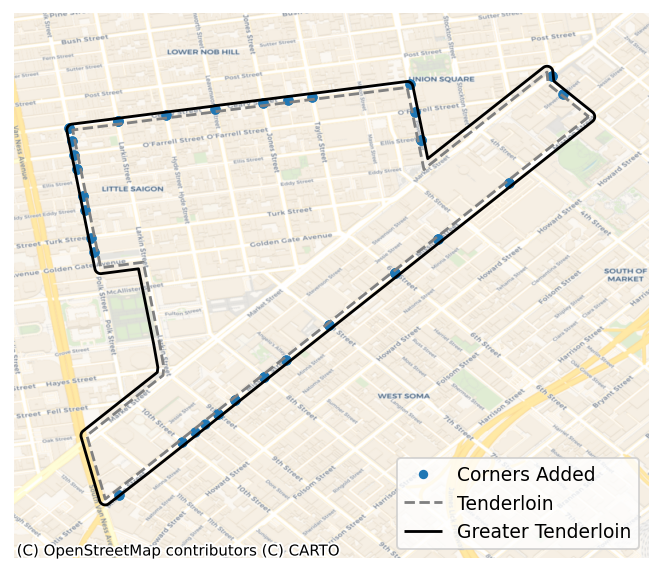

In [51]:
#| warnings: false
#| label: fig-gt
#| fig-cap: "The Greater Tenderloin"  

gains = (~corners_gdf.within(arrests_by_dist.set_index('police_district').loc['tenderloin', 'geometry'])) & (corners_gdf['Tenderloin or\nWithin ~2 Blocks\nof Tenderloin'])
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
geospatial_utils.clean_map(ax)
geospatial_utils.zoom_district(ax, 'tenderloin',  arrests_by_dist, column='police_district', zoom=.2)
ax.plot(*corners_gdf[gains].iloc[0].geometry.coords[0], "o", label="Corners Added", markersize=4)
arrests_by_dist[arrests_by_dist['police_district'] == 'tenderloin'].boundary.plot(ax=ax, linestyle="--", edgecolor="grey", label="Tenderloin")
gt_area.plot(ax=ax, edgecolor="black", label="Greater Tenderloin")
corners_gdf[gains].plot(ax=ax, markersize=20)
cx.add_basemap(ax=ax, crs=gdf_full.crs, source=cx.providers.CartoDB.Voyager)
ax.legend(loc="lower right")
fig.tight_layout()
fig.set_dpi(135)

In [52]:
drug_sale_definition = (
    arrests_df[arrests_df['drug_sale']]
    .groupby('incident_description')
    ['incident_id'].nunique()
    .sort_values(ascending=False)
    .to_frame("Frequency")
    .rename_axis('Drug Sale Arrest Description')
    .reset_index()
    .style
    .format({'Frequency': '{:,}',})
    .hide(axis="index")
    )
drug_non_sale_definition = (
    arrests_df[arrests_df['drug_non_sale']]
    .groupby('incident_description')
    ['incident_id'].nunique()
    .sort_values(ascending=False)
    .to_frame("Frequency")
    .rename_axis('Drug Use Arrest Description')
    .reset_index()
    .style
    .format({'Frequency': '{:,}',})
    .hide(axis="index")
    )

#### Defining "Drug use" arrests {#sec-drug-use}
In the arrest data, there is an arrest type, "Drug," which contains all drug related offenses. I split this category into two sub-groups -- drug sale arrests, and drug use/non sale arrests. All arrests in the broad "Drug" category are also members of one of these two subgroups. I define Drug use, or, non-drug sale arrests, as those drug crimes that do not contain the phrase "sale" in their description.

In [53]:
drug_non_sale_definition

Drug Use Arrest Description,Frequency
"Narcotics Paraphernalia, Possession of","4,349"
Methamphetamine Offense,"1,446"
Controlled Substance Offense,318
Heroin Offense,298
Opiates Offense,284
Loitering Where Narcotics are Sold/Used,249
"Cocaine, Base/rock Offense",231
Marijuana Offense,227
"Firearm, Armed While Possessing Controlled Substance",207
Cocaine Offense,161


#### Defining "Drug sale" arrests {#sec-drug-sale}  

Drug sale arrests are those arrests in the "Drugs" category that contain the word "sale" in their description.

In [54]:
drug_sale_definition

Drug Sale Arrest Description,Frequency
"Methamphetamine, Possession For Sale","2,063"
"Cocaine, Base/rock, Possession For Sale","1,862"
"Heroin, Possession For Sale","1,429"
"Opiates, Possession For Sale",898
"Controlled Substance, Possession For Sale",880
"Cocaine, Base/rock, Sale",523
"Cocaine, Possession For Sale",430
"Methamphetamine, Sale",252
"Controlled Substance, Sale",232
"Marijuana, Possession For Sale",182


<!-- ::: -->

<!-- ::: {.callout-note appearance="minimal" collapse=true} -->

### Methods Appendix
In this memo, I used the following core statistical test for examining changes in arrest activity:

$$
arrests_t = \hat{\beta_0} + \hat{\beta_{1}}post_t + \epsilon_t
$${#eq-ols}

The estimate of interest is $\hat{\beta_{1}}$, which represents the average increase in weekly arrests in the post-pandemic, 2022-2024, relative to the pre-pandemic, 2018-2020. $\hat{\beta_{0}}$ is the average weekly arrest level in the pre-pandemic and $\hat{\beta_{0}} + \hat{\beta_{1}}$ is the average arrest level in the post-pandemic. I test the hypothesis that the average weekly arrest level in the post-pandemic was different from the average weekly arrest level in the pre-pandemic:  

$$
H_0: \beta_{1} = 0, \quad H_1: \beta_{1} \neq 0
$${#eq-h}
  
I repeat the estimation of @eq-ols and test @eq-h for each arrest type, a total of `{python} ols_models_df.shape[0]` times, once at the city-level, and once in the greater Tenderloin. I obtain the standard errors presented in the memo via a block bootstrap procedure, with weeks clustered into four-unit groups to address autocorrelation in the week-level time series. 

Repeated hypothesis testing introduces the issue of *multiple testing*, where every additional test we conduct raises the probability that we made a false discovery of change [@james_introduction_2021, chap 13]. To adjust for multiple testing, I apply a Bonferroni correction to the hypothesis tests. Specifically, for a 95% confidence interval, where one would typically test with a threshold for the probability of a false positive, $\alpha = .05$,^[ $CI = 1 - \alpha = 1 - .05 = .95$ ] the Bonferroni correction instead tests with $\alpha = .05/m$, where $m$ is the number of hypotheses being tested [@james_introduction_2021, chap 13]. In this case, $m=$ `{python} ols_models_df.shape[0]`, implying a threshold $.05/$ `{python} ols_models_df.shape[0]` $=$ `{python} round(.05/ols_models_df.shape[0], 4)` and confidence intervals that cover `{python} 100* round(1 - .05/ols_models_df.shape[0], 4)`%.  

#### Robustness checks

One potential issue with the modeling approach is that the Bonferroni correction can be overly conservative when the amount of hypotheses being tested is very large or sample sizes are very small. However, in this setting, where only `{python} ols_models_df.shape[0]` related hypotheses are being tested and the week-level time series is not especially small at $n=$ `{python} len(testing_day_df)`, the Bonferroni correction can still be an appropriate adjustment [@vanderweele_desirable_2019]. Regardless, to test if the conservatism of the correction meaningfully changes the results of the policy analysis, I fit models with and without it.

I also conduct robustness checks on the standard error specification. In the memo, I present the block-bootstrap standard errors because they rely on minimal assumptions about the structure of the data. However, I present results from two alternatives -- Newey-West standard errors, and ordinary least squares (OLS) standard errors -- to test robustness of the findings.

Each of these specifications are theoretically inferior to the block-bootstrap approach, but the use of mis-specified OLS is so common in practice as to merit inclusion. @eq-ols, when estimated using ordinary least squares (OLS), produces standard errors valid under the following assumptions:  

1. The error term is normally distributed with constant variance and mean zero: $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
2. Weekly arrests are continuous and distributed normally: $arrests \in \mathbb{R}$ and $arrests \sim \mathcal{N}(\mu, \sigma^2)$

In the context of weekly arrest totals, which are a time-series that exhibit autocorrelation, the first assumption of constant variance may be problematic. Both Newey-West estimation and the block bootstrap are robust to this issue. Arrest count data, which are typically small, positive integers, don't conform to the structure set forth in the second assumption. The block bootstrap is the only specification present that is robust to this issue. Thus, the bootstrap should be the best approach under the circumstances.

##### Results

[@tbl-robust-city] shows that changing testing specifications has no impact on any statistical or policy conclusions made at the City-level in the memo.  

[@tbl-robust-tl] shows that testing specification does not affect core conclusions about drug sale arrests in the greater Tenderloin. However, specification does affect the conclusion presented in the memo that larceny theft, robbery, traffic and drug use arrests did not change in the greater Tenderloin in the post-pandemic. Much of this is due to the fact that OLS becomes an increasingly tenuous approach in the Tenderloin, where weekly arrest counts are often small and clustered near 0, a clear challenge to OLS modeling assumptions. 

- Drug use: using OLS with no Bonferroni correction yields a statistically significant increase in drug use arrests. This is a mis-specified test that does not take into account the structure of the data or possible multiple testing issues. All other tests concluded that there was no statistically significant change. Still, the effect is not trivially small, so I temper my conclusion that this arrest class did not increase and encourage further research into this arrest type in particular.  
- Larceny theft: similarly, using OLS with no Bonferroni correction yields a statistically significant estimate, while all other tests conclude there was no change. In this case, the change is also practically negligible (less than one arrest a week). In the memo , I report no change in larceny theft arrests in the greater Tenderloin.
- Robbery: every specification that does not utilize the Bonferroni correction yields a small, statistically significant decrease, and every specification with the correction yields no change. In this case, a next step would be using a less conservative correction for multiple testing [@james_introduction_2021, chap 13]. However, given that the effect size is particularly small, I defer to the core specification and report no change in the memo.
- Traffic: tests present a mixed bag and a practically negligible effect size. In the memo I defer to conclusions of the core bootstrap specification.

In [55]:
#| label: tbl-robust-city
#| tbl-cap: "Full City -- robustness checks for changes in arrest activity"
robust_table = pd.concat([
    ols_models_df.assign(model="OLS"),
    ols_models_nb_df.assign(model="OLS, no Bonferroni"),
    bs_models_df.assign(model="Block Bootstrap (block=4)"),
    bs_models_nb_df.assign(model="Block Bootstrap, no Bonferroni"),
    newey_models_df.assign(model="Newey West (lags=3)"),
    newey_models_nb_df.assign(model="Newey West, no Bonferroni")
    ]).reset_index().dropna(axis=1)
robust_table.columns = ['Outcome', 'Coefficient', 'Lower bound', 'Upper bound', 'Significant', 'Model']
robust_table['Outcome'] = robust_table['Outcome'].str.replace("_", " ").str.title()
robust_table.groupby(['Outcome', 'Model']).max()

Coefficient  Lower bound  \
Outcome       Model                                                      
Assault       Block Bootstrap (block=4)         -7.876190   -10.182692   
              Block Bootstrap, no Bonferroni    -7.876190    -9.509615   
              Newey West (lags=3)               -7.876200   -11.169000   
              Newey West, no Bonferroni         -7.876200   -10.193000   
              OLS                               -7.876200   -10.985000   
              OLS, no Bonferroni                -7.876200   -10.063000   
Burglary      Block Bootstrap (block=4)         -0.523810    -1.540625   
              Block Bootstrap, no Bonferroni    -0.523810    -1.250000   
              Newey West (lags=3)               -0.523800    -1.652000   
              Newey West, no Bonferroni         -0.523800    -1.317000   
              OLS                               -0.523800    -1.708000   
              OLS, no Bonferroni                -0.523800    -1.357000   
Drug Non Sale Block Bootstrap (block=4)         -3.066667   -10.041827   
              Block Bootstrap, no Bonferroni    -3.066667    -8.115625   
              Newey West (lags=3)               -3.066700   -10.623000   
              Newey West, no Bonferroni         -3.066700    -8.383000   
              OLS                               -3.066700    -7.997000   
              OLS, no Bonferroni                -3.066700    -6.535000   
Drug Sale     Block Bootstrap (block=4)          7.428571     1.889904   
              Block Bootstrap, no Bonferroni     7.428571     3.432692   
              Newey West (lags=3)                7.428600     2.006000   
              Newey West, no Bonferroni          7.428600     3.614000   
              OLS                                7.428600     2.813000   
              OLS, no Bonferroni                 7.428600     4.181000   
Homicide      Block Bootstrap (block=4)          0.047619    -0.059856   
              Block Bootstrap, no Bonferroni     0.047619    -0.038462   
              Newey West (lags=3)                0.047600    -0.058000   
              Newey West, no Bonferroni          0.047600    -0.027000   
              OLS                                0.047600    -0.053000   
              OLS, no Bonferroni                 0.047600    -0.023000   
Larceny Theft Block Bootstrap (block=4)         -9.571429   -12.384615   
              Block Bootstrap, no Bonferroni    -9.571429   -11.740385   
              Newey West (lags=3)               -9.571400   -12.820000   
              Newey West, no Bonferroni         -9.571400   -11.857000   
              OLS                               -9.571400   -12.127000   
              OLS, no Bonferroni                -9.571400   -11.369000   
Robbery       Block Bootstrap (block=4)         -3.066667    -4.396394   
              Block Bootstrap, no Bonferroni    -3.066667    -4.019231   
              Newey West (lags=3)               -3.066700    -4.298000   
              Newey West, no Bonferroni         -3.066700    -3.933000   
              OLS                               -3.066700    -4.181000   
              OLS, no Bonferroni                -3.066700    -3.850000   
Traffic       Block Bootstrap (block=4)        -19.819048   -24.129327   
              Block Bootstrap, no Bonferroni   -19.819048   -22.884615   
              Newey West (lags=3)              -19.819000   -23.714000   
              Newey West, no Bonferroni        -19.819000   -22.559000   
              OLS                              -19.819000   -22.734000   
              OLS, no Bonferroni               -19.819000   -21.870000   
Weapons       Block Bootstrap (block=4)         -1.171429    -3.127163   
              Block Bootstrap, no Bonferroni    -1.171429    -2.461538   
              Newey West (lags=3)               -1.171400    -3.618000   
              Newey West, no Bonferroni         -1.171400    -2.893000   
              OLS                               -1

In [56]:
#| label: tbl-robust-tl
#| tbl-cap: "Greater Tenderloin -- robustness checks for changes in arrest activity"
robust_table = pd.concat([
    ols_models_df_t.assign(model="OLS"),
    ols_models_nb_df_t.assign(model="OLS, no Bonferroni"),
    bs_models_df_t.assign(model="Block Bootstrap (block=4)"),
    bs_models_nb_df_t.assign(model="Block Bootstrap, no Bonferroni"),
    newey_models_df_t.assign(model="Newey West (lags=3)"),
    newey_models_nb_df_t.assign(model="Newey West, no Bonferroni")
    ]).reset_index().dropna(axis=1)
robust_table.columns = ['Outcome', 'Coefficient', 'Lower bound', 'Upper bound', 'Significant', 'Model']
robust_table['Outcome'] = robust_table['Outcome'].str.replace("_", " ").str.title()
robust_table.groupby(['Outcome', 'Model']).max()

Coefficient  Lower bound  \
Outcome       Model                                                      
Assault       Block Bootstrap (block=4)         -0.533333    -1.403846   
              Block Bootstrap, no Bonferroni    -0.533333    -1.144231   
              Newey West (lags=3)               -0.533300    -1.650000   
              Newey West, no Bonferroni         -0.533300    -1.319000   
              OLS                               -0.533300    -1.626000   
              OLS, no Bonferroni                -0.533300    -1.302000   
Burglary      Block Bootstrap (block=4)         -0.076190    -0.394231   
              Block Bootstrap, no Bonferroni    -0.076190    -0.307692   
              Newey West (lags=3)               -0.076200    -0.397000   
              Newey West, no Bonferroni         -0.076200    -0.302000   
              OLS                               -0.076200    -0.377000   
              OLS, no Bonferroni                -0.076200    -0.288000   
Drug Non Sale Block Bootstrap (block=4)          3.561905    -1.723317   
              Block Bootstrap, no Bonferroni     3.561905    -0.326923   
              Newey West (lags=3)                3.561900    -2.601000   
              Newey West, no Bonferroni          3.561900    -0.774000   
              OLS                                3.561900    -0.054000   
              OLS, no Bonferroni                 3.561900     1.018000   
Drug Sale     Block Bootstrap (block=4)          6.704762     1.521154   
              Block Bootstrap, no Bonferroni     6.704762     3.115385   
              Newey West (lags=3)                6.704800     1.774000   
              Newey West, no Bonferroni          6.704800     3.236000   
              OLS                                6.704800     2.671000   
              OLS, no Bonferroni                 6.704800     3.867000   
Homicide      Block Bootstrap (block=4)          0.009524     0.000000   
              Block Bootstrap, no Bonferroni     0.009524     0.000000   
              Newey West (lags=3)                0.009500    -0.017000   
              Newey West, no Bonferroni          0.009500    -0.009000   
              OLS                                0.009500    -0.017000   
              OLS, no Bonferroni                 0.009500    -0.009000   
Larceny Theft Block Bootstrap (block=4)         -0.885714    -2.081250   
              Block Bootstrap, no Bonferroni    -0.885714    -1.769231   
              Newey West (lags=3)               -0.885700    -2.504000   
              Newey West, no Bonferroni         -0.885700    -2.024000   
              OLS                               -0.885700    -1.993000   
              OLS, no Bonferroni                -0.885700    -1.665000   
Robbery       Block Bootstrap (block=4)         -0.361905    -0.761779   
              Block Bootstrap, no Bonferroni    -0.361905    -0.644231   
              Newey West (lags=3)               -0.361900    -0.750000   
              Newey West, no Bonferroni         -0.361900    -0.635000   
              OLS                               -0.361900    -0.748000   
              OLS, no Bonferroni                -0.361900    -0.634000   
Traffic       Block Bootstrap (block=4)         -0.895238    -2.221154   
              Block Bootstrap, no Bonferroni    -0.895238    -1.807692   
              Newey West (lags=3)               -0.895200    -1.959000   
              Newey West, no Bonferroni         -0.895200    -1.644000   
              OLS                               -0.895200    -1.716000   
              OLS, no Bonferroni                -0.895200    -1.473000   
Weapons       Block Bootstrap (block=4)          0.342857    -0.569471   
              Block Bootstrap, no Bonferroni     0.342857    -0.307933   
              Newey West (lags=3)                0.342900    -0.622000   
              Newey West, no Bonferroni          0.342900    -0.336000   
              OLS                                0

<!-- ::: -->

#### References
:::{#refs}
:::

In [57]:
# #| label: tbl-a-1
# #| tbl-cap: "Geographic Trends in Arrests (2018-2024), by Police District"
# arrests_by_dist['Percent of Total'] = arrests_by_dist['Arrests'] / arrests_by_dist['Arrests'].sum()
# (arrests_by_dist
#  .rename(columns={'police_district': 'District'})
#  [['District', 'Arrests', 'Percent of Total']]
#  .sort_values(by='Percent of Total', ascending=False)
#  .style.format({'Arrests': '{:,}', 'Percent of Total': '{:.0%}'}, precision=2)
#  .hide(axis="index")
#  )